In [1]:
# import packages
import numpy as np
import anndata as ad
import scanpy as sc
import tangram as tg
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re
import scanpy.external as sce

#import scimap as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [2]:

# Set the working directory
os.chdir('/Users/m.ando/surfdrive - Masami Ando Kuri@surfdrive.surf.nl/Documents/HCC/NASH/Resolve_ST')

# Confirm the current working directory
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/m.ando/surfdrive - Masami Ando Kuri@surfdrive.surf.nl/Documents/HCC/NASH/Resolve_ST


## Load results

In [3]:
#Load predictions
#ad_ge_end = sc.read_h5ad("Tangram_allsubclusters_Endstage_RESOLVE_Endstage.h5ad")
#ad_ge_end

merged_adata = sc.read_h5ad("RESOLVE_allstages_mergedST.h5ad")
merged_adata
#Go to Filter by stage

AnnData object with n_obs × n_vars = 194951 × 88
    obs: 'cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'n_counts', 'Slide_section', 'leiden', 'Sample_names', 'Slides'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### Functions:


In [4]:
#https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

def resolve_to_anndata(count_matrix_path, segmentation_coords):
    data = pd.read_csv(count_matrix_path, delimiter=";",header=0) # Counts matrix
    
    geneids = data.iloc[:,0].tolist()
    cellids = data.columns.tolist()[1:]
    coordinates = pd.read_csv(segmentation_coords) # Meta data like x and y coordinates 
    coordinates.index = coordinates["cell"]
    
    # combine the data and metadata file to generate the AnnData object
    adata = ad.AnnData(data.iloc[:,data.columns!="Unnamed: 0"].transpose(), obsm={"spatial": coordinates.iloc[:,1:3]})
    
    #Assign
    adata.var_names = geneids #Gene
    meta = pd.read_csv(segmentation_coords) # Meta data like x and y coordinates 
    adata.obs = meta
    adata.obs_names = cellids #Cell
    # Add marker annotation
    adata.uns['all_markers'] = geneids
    return adata


#https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_short_demo_downstream.html
# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Read scRNAseq data

In [5]:
#adata_sc = sc.read(filename="/Volumes/Group Akkari/Akkari lab papers/2024 - MASH HCC/Spatial_transcriptomics_RESOLVE/subcluster_annotated_RasV.h5ad")
#adata_sc

adata_sc = sc.read(filename="/Users/m.ando/surfdrive - Masami Ando Kuri@surfdrive.surf.nl/Documents/HCC/NASH/Resolve_ST/subcluster_annotated_RasV.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 73268 × 24461
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'replicate', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.08', 'seurat_clusters', 'SCT_snn_res.0.07', 'batch', 'SCT_snn_res.0.06', 'SCT_snn_res.0.1', 'anchor_pred', 'celltype_wide', 'cell_type', 'cell_subtype'
    var: 'features'
    obsm: 'X_umap'

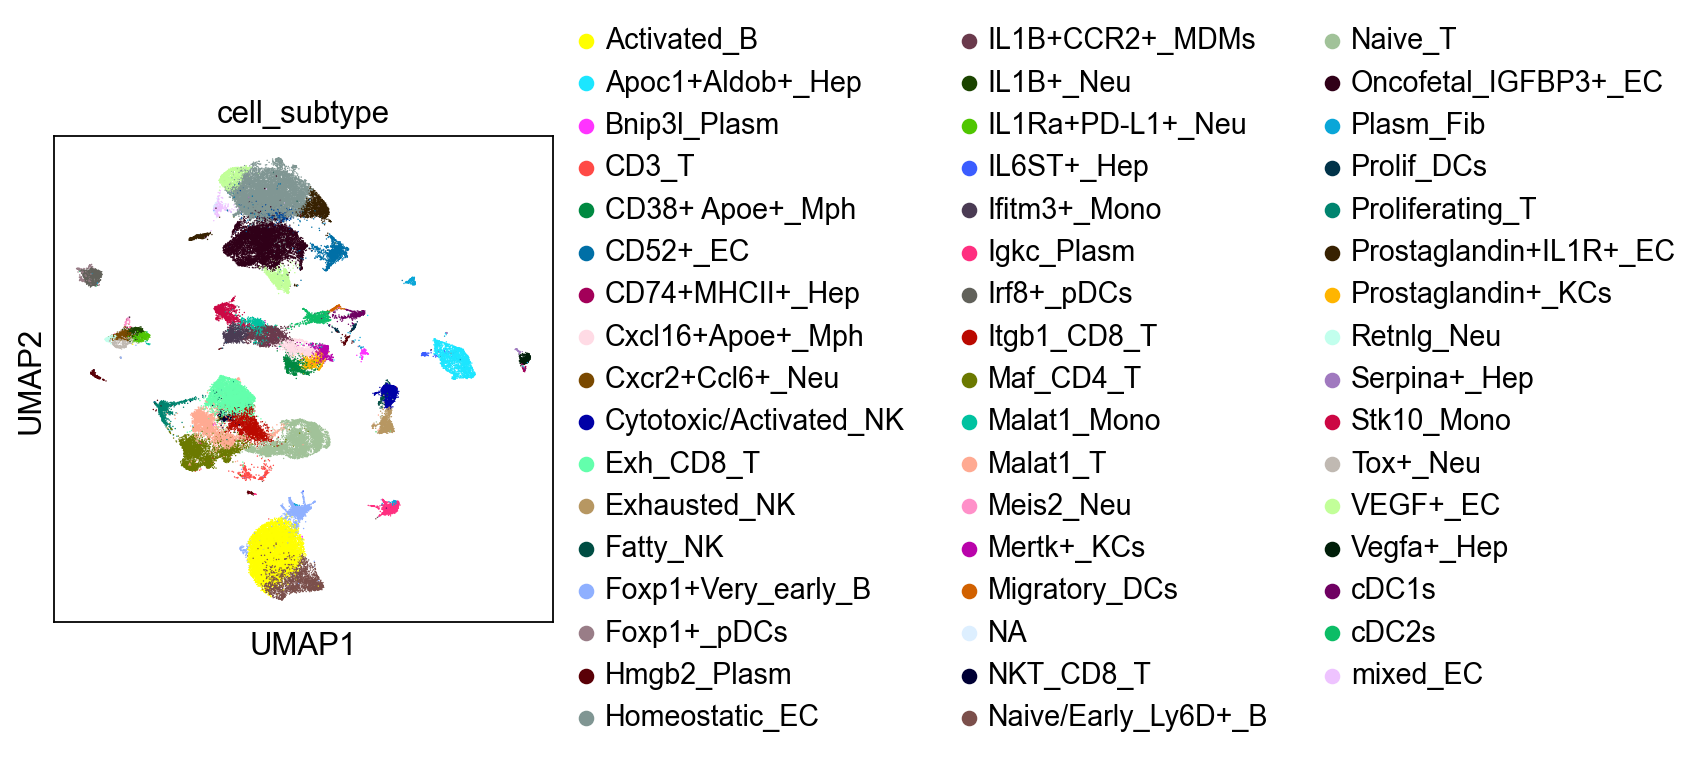

In [6]:
sc.pl.umap(adata_sc, color="cell_subtype")

## Read Spatial Transcriptomics: RESOLVE

In [29]:
#PATH where files are stored
#count_results_path = "/Volumes/Group Akkari/Individual folders/Masami/HCC/resolve_RasV/33657-slide1_submission/Segmentation_results_counts_per_cell/Segmentation_Baysor/"
#segmentationcood_results_path = "/Volumes/Group Akkari/Individual folders/Masami/HCC/resolve_RasV/33657-slide1_submission/Segmentation_results/Baysor/"

count_results_path = "/Users/m.ando/surfdrive - Masami Ando Kuri@surfdrive.surf.nl/Documents/HCC/NASH/Resolve_ST/Segmentation_results_counts_per_cell/Segmentation_Baysor/"
segmentationcood_results_path = "/Users/m.ando/surfdrive - Masami Ando Kuri@surfdrive.surf.nl/Documents/HCC/NASH/Resolve_ST/Segmentation_results/Baysor/"


# Define the base directories to search for files
count_results_perslide_path = ["clus-res_33657-slide1_A1-2_results_cell_segmentation_2024-09-05-09-07-00",
"clus-res_33657-slide1_A1-3_results_cell_segmentation_2024-09-05-09-16-38",
"clus-res_33657-slide1_A1-4_results_cell_segmentation_2024-09-05-09-25-47",
"clus-res_33657-slide1_A1-5_results_cell_segmentation_2024-09-05-09-27-05",
"clus-res_33657-slide1_A2-2_results_cell_segmentation_2024-09-05-09-30-26",
"clus-res_33657-slide1_A2-3_results_cell_segmentation_2024-09-05-09-31-39",
"clus-res_33657-slide1_A2-4_results_cell_segmentation_2024-09-05-09-34-57",
"clus-res_33657-slide1_B1-1_results_cell_segmentation_2024-09-05-09-37-01",
"clus-res_33657-slide1_B2-3_results_cell_segmentation_2024-09-05-10-24-10",
"clus-res_33657-slide1_B2-4_results_cell_segmentation_2024-09-05-10-28-01",
"clus-res_33657-slide1_C1-3_results_cell_segmentation_2024-09-05-10-48-33",
"clus-res_33657-slide1_C2-1_results_cell_segmentation_2024-09-05-10-50-25",
"clus-res_33657-slide1_C2-2_results_cell_segmentation_2024-09-05-10-51-02",
"clus-res_33657-slide1_D1-1_results_cell_segmentation_2024-09-05-08-45-41",
"clus-res_33657-slide1_D2-2_results_cell_segmentation_2024-09-05-10-55-47",
"clus-res_33657-slide1_D2-3_results_cell_segmentation_2024-09-05-10-57-08",
"clus-res_33657-slide1_D2-4_results_cell_segmentation_2024-09-05-10-59-33"]



# Define the base directories to search for files
segmentationcoord_results_perslide_path = ["33657-slide1_A1-2_results_baysor_results",
"33657-slide1_A1-3_results_baysor_results",
"33657-slide1_A1-4_results_baysor_results",
"33657-slide1_A1-5_results_baysor_results",
"33657-slide1_A2-2_results_baysor_results",
"33657-slide1_A2-3_results_baysor_results",
"33657-slide1_A2-4_results_baysor_results",
"33657-slide1_B1-1_results_baysor_results",
"33657-slide1_B2-3_results_baysor_results",
"33657-slide1_B2-4_results_baysor_results",
"33657-slide1_C1-3_results_baysor_results",
"33657-slide1_C2-1_results_baysor_results",
"33657-slide1_C2-2_results_baysor_results",
"33657-slide1_D1-1_results_baysor_results",
"33657-slide1_D2-2_results_baysor_results",
"33657-slide1_D2-3_results_baysor_results",
"33657-slide1_D2-4_results_baysor_results"]

#Extra information
Samples_names=np.repeat("End_stage",7).tolist()+np.repeat("Pretumor_2months",3).tolist()+np.repeat("Control",3).tolist()+np.repeat("End_stage",1).tolist()+np.repeat("Pretumor_2months",3).tolist()
Slides_section=[re.sub("33657-slide1_|_results_baysor_results", "", slide) for slide in segmentationcoord_results_perslide_path]
Slides=[re.sub("33657-slide1_|-[0-9]_results_baysor_results", "", slide) for slide in segmentationcoord_results_perslide_path]

In [30]:
# Initialize a list to store DataFrames
addf = []


# Loop through each base directory
for base_dir,base_dirmeta in zip(count_results_perslide_path, segmentationcoord_results_perslide_path):
    
    # Use glob to find all CSV files in the current directory
    files = os.path.join(count_results_path+base_dir+ "/raw_countmatrix.csv");
    files_metadata = os.path.join(segmentationcood_results_path+base_dirmeta+ "/baysor_cell_stats.csv");
    #print(files_metadata)
    anndata_object = resolve_to_anndata(count_matrix_path=files, segmentation_coords=files_metadata)
   # List to store AnnData objects
    addf.append(anndata_object)

addf

[AnnData object with n_obs × n_vars = 8259 × 100
     obs: 'cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence'
     uns: 'all_markers'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 5772 × 100
     obs: 'cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence'
     uns: 'all_markers'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 8246 × 99
     obs: 'cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence'
     uns: 'all_markers'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 5521 × 100
     obs: 'cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence'
     uns: 'all_markers'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 17561 × 100
     obs: 'cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence'
     uns: 'all_markers'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 14644 × 100


### Calculate quality control metrics

In [31]:
# Filter  genes that are detected in less than 10 cells
for adata in addf:
    sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50), inplace=True)
  #filtered out X genes that are detected in less than 10 cells
    sc.pp.filter_cells(adata, min_counts=50)
    sc.pp.filter_genes(adata, min_cells=10)
    adata.layers["counts"] = adata.X.copy()

filtered out 540 cells that have less than 50 counts
filtered out 329 cells that have less than 50 counts
filtered out 3 genes that are detected in less than 10 cells
filtered out 1252 cells that have less than 50 counts
filtered out 2 genes that are detected in less than 10 cells
filtered out 618 cells that have less than 50 counts
filtered out 3 genes that are detected in less than 10 cells
filtered out 953 cells that have less than 50 counts
filtered out 1 genes that are detected in less than 10 cells
filtered out 1328 cells that have less than 50 counts
filtered out 525 cells that have less than 50 counts
filtered out 3 genes that are detected in less than 10 cells
filtered out 2012 cells that have less than 50 counts
filtered out 715 cells that have less than 50 counts
filtered out 5 genes that are detected in less than 10 cells
filtered out 1993 cells that have less than 50 counts
filtered out 2106 cells that have less than 50 counts
filtered out 1054 cells that have less than 50

### Merge data into one object

In [32]:
# Initialize an empty list to collect AnnData objects
merged_adatas = []

# Loop through the list of AnnData objects (you can also loop through files to load them)
for adata in addf:
    # Append each AnnData object to the list
    merged_adatas.append(adata)

# Merge all AnnData objects using ad.concat()
merged_adata = ad.concat(merged_adatas,keys=pd.Categorical(Slides_section), label="Slide_section", join="inner")

merged_adata

AnnData object with n_obs × n_vars = 194951 × 88
    obs: 'cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'n_counts', 'Slide_section'
    obsm: 'spatial'
    layers: 'counts'

## Normalization + clustering

In [14]:
merged_adata.layers["counts"] = merged_adata.X.copy()
sc.pp.normalize_total(merged_adata, inplace=True)
sc.pp.log1p(merged_adata)
sc.pp.pca(merged_adata)
sc.pp.neighbors(merged_adata)
sc.tl.umap(merged_adata)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:21)


In [19]:
sc.tl.leiden(merged_adata, resolution =0.5, flavor="igraph")

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


In [20]:
# Create dictionary from two lists
dictionary_samples = dict(zip(Slides_section, Samples_names))
dictionary_samples.items()

dict_items([('A1-2', 'End_stage'), ('A1-3', 'End_stage'), ('A1-4', 'End_stage'), ('A1-5', 'End_stage'), ('A2-2', 'End_stage'), ('A2-3', 'End_stage'), ('A2-4', 'End_stage'), ('B1-1', 'Pretumor_2months'), ('B2-3', 'Pretumor_2months'), ('B2-4', 'Pretumor_2months'), ('C1-3', 'Control'), ('C2-1', 'Control'), ('C2-2', 'Control'), ('D1-1', 'End_stage'), ('D2-2', 'Pretumor_2months'), ('D2-3', 'Pretumor_2months'), ('D2-4', 'Pretumor_2months')])

In [21]:
#Add meta information 
merged_adata.obs["Sample_names"] =pd.Categorical([dictionary_samples[key] for key in merged_adata.obs["Slide_section"].tolist() if key in dictionary_samples], categories=['Control', 'Pretumor_2months', 'End_stage'])
merged_adata.obs["Slides"] =[re.sub("-[0-9]", "", slide) for slide in merged_adata.obs["Slide_section"]]
merged_adata.obs

cell            x            y  \
Cell1_43_2174            Cell1_43_2174    43.012500  2174.041667   
Cell2_35_2314            Cell2_35_2314    34.677500  2314.003750   
Cell3_2171_91            Cell3_2171_91  2171.299539    91.230415   
Cell4_2174_192          Cell4_2174_192  2173.641631   191.978541   
Cell5_144_2254          Cell5_144_2254   144.360551  2254.329799   
...                                ...          ...          ...   
Cell3579_5489_5198  Cell3579_5489_5198  5488.847953  5197.766082   
Cell3582_5753_2651  Cell3582_5753_2651  5752.571429  2650.610390   
Cell3583_3819_4156  Cell3583_3819_4156  3819.291667  4155.652778   
Cell3587_730_1544    Cell3587_730_1544   729.961538  1544.134615   
Cell3589_6333_5622  Cell3589_6333_5622  6332.597484  5622.465409   

                    n_transcripts  density  elongation     area  \
Cell1_43_2174                 240  0.05245       2.094   4576.0   
Cell2_35_2314                 800  0.04969       8.677  16100.0   
Cell3_2171_91                 217  0.05889       2.329   3685.0   
Cell4_2174_192                466  0.08507       1.923   5478.0   
Cell5_144_2254                943  0.04953       3.363  19040.0   
...                           ...      ...         ...      ...   
Cell3579_5489_5198            171  0.03354       4.535   5098.0   
Cell3582_5753_2651             77  0.02176       2.526   3538.0   
Cell3583_3819_4156             72  0.03077       3.832   2340.0   
Cell3587_730_1544              52  0.03951       4.251   1316.0   
Cell3589_6333_5622            159  0.06589       1.167   2413.0   

                    avg_confidence  n_genes_by_counts  \
Cell1_43_2174               0.9958                 30   
Cell2_35_2314               0.9974                 39   
Cell3_2171_91               0.9925                 26   
Cell4_2174_192              0.9984                 23   
Cell5_144_2254              0.9961                 31   
...                            ...                ...   
Cell3579_5489_5198          0.9964                 24   
Cell3582_5753_2651          0.9910                 16   
Cell3583_3819_4156          0.9983                 14   
Cell3587_730_1544           0.9999                  8   
Cell3589_6333_5622          0.9994                 22   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
Cell1_43_2174                      3.433987           240            5.484797   
Cell2_35_2314                      3.688879           800            6.685861   
Cell3_2171_91                      3.295837           217            5.384495   
Cell4_2174_192                     3.178054           466            6.146329   
Cell5_144_2254                     3.465736           943            6.850126   
...                                     ...           ...                 ...   
Cell3579_5489_5198                 3.218876           171            5.147494   
Cell3582_5753_2651                 2.833213            77            4.356709   
Cell3583_3819_4156                 2.708050            72            4.290459   
Cell3587_730_1544                  2.197225            52            3.970292   
Cell3589_6333_5622                 3.135494           159            5.075174   

                    pct_counts_in_top_10_genes  pct_counts_in_top_20_genes  \
Cell1_43_2174                        83.333333                   95.000000   
Cell2_35_2314                        86.250000                   95.500000   
Cell3_2171_91                        86.635945                   97.235023   
Cell4_2174_192                       95.064378                   99.356223   
Cell5_144_2254                       89.925769                   97.560976   
...                                        ...                         ...   
Cell3579_5489_5198                   88.888889                   97.660819   
Cell3582_5753_2651                   92.207792                  100.000000   
Cell3583_3819_4156                   94.444444      

In [22]:
sce.pp.harmony_integrate(merged_adata, 'Sample_names')
'X_pca_harmony' in merged_adata.obsm

2024-11-19 14:22:53,495 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-19 14:23:03,763 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-19 14:23:04,116 - harmonypy - INFO - Iteration 1 of 10
2024-11-19 14:23:41,163 - harmonypy - INFO - Iteration 2 of 10
2024-11-19 14:24:15,266 - harmonypy - INFO - Converged after 2 iterations


True

In [24]:
import seaborn as sns
colors = sns.color_palette('colorblind', as_cmap=True) + sns.color_palette('deep', as_cmap=True)
colors.pop(10)
colors.pop(10)
shuffled_indices = np.random.permutation(merged_adata.n_obs)

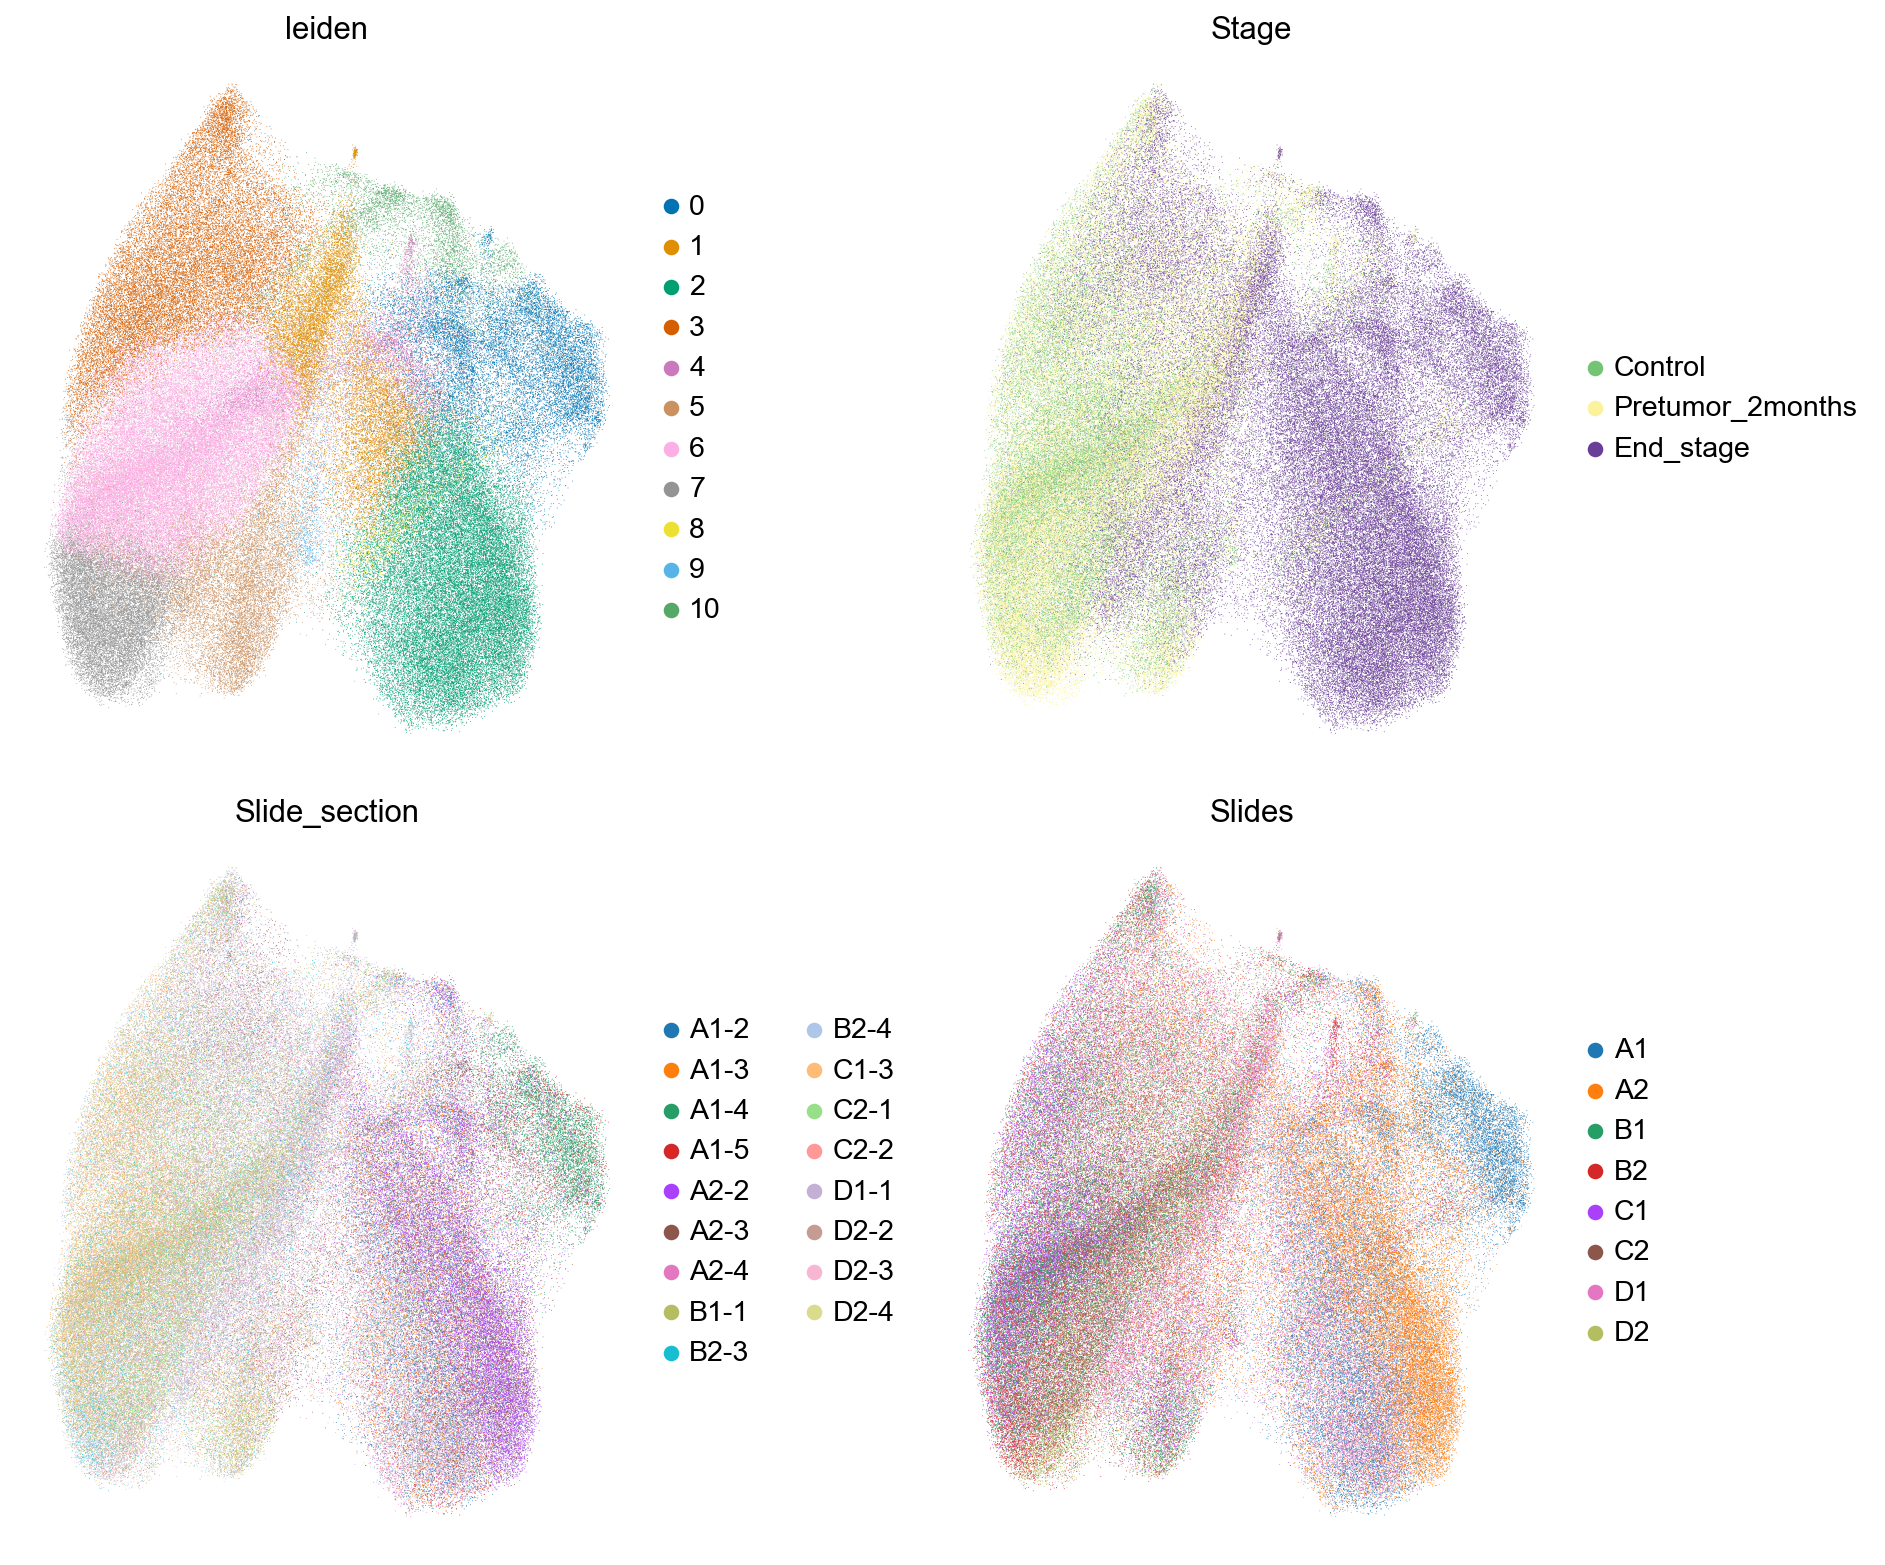

In [25]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('UMAPs_clusters_intergratedsamples.pdf') as pdf:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots

    sc.pl.embedding(merged_adata[shuffled_indices, :],ax=axs[0,0], basis="umap", color="leiden",frameon=False, show=False, palette=colors,wspace=0.5)
    axs[0,0].set_title('leiden')

    sc.pl.embedding(merged_adata[shuffled_indices, :], ax=axs[0,1],basis="umap", color="Sample_names", show=False,frameon=False, palette={"Control":"#74C476", "Pretumor_2months":"#FAF39B", "End_stage":"#6A3E98" },wspace=0.5)
    axs[0,1].set_title('Stage')

    sc.pl.embedding(merged_adata[shuffled_indices, :], ax=axs[1,0],basis="umap", color="Slide_section", show=False,frameon=False,wspace=0.5)
    axs[1,0].set_title('Slide_section')
    
    sc.pl.embedding(merged_adata[shuffled_indices, :], ax=axs[1,1],basis="umap", color="Slides", show=False,frameon=False,wspace=0.5)
    axs[1,1].set_title('Slides')

    plt.tight_layout()
    pdf.savefig(fig)

In [26]:
merged_adata.write("RESOLVE_allstages_mergedST.h5ad")


In [28]:
set(merged_adata.obs['Sample_names'])

{'Control', 'End_stage', 'Pretumor_2months'}

#### Filter by stage: Control

In [7]:
mask = np.in1d(adata_sc.obs["condition"], ["ctl"])
adata_sc_ctl = adata_sc[mask]
#adata_sc_ctl
merged_adata_ctl = merged_adata[merged_adata.obs['Sample_names']=="Control"]


## Common gene set between reference and spatial dataset

In [8]:
markers = list(set.intersection(set(adata_sc_ctl.var_names), set(merged_adata_ctl.var_names)))
len(markers)

88

tg.pp_adatas does the following:

Computes the overlap between single-cell data and spatial data on the list of genes provided in the genes argument
Stores the resulting gene set under 'training_genes' in both adata objects under the .uns key
Enforces consistent ordering of the genes
To reduce potential naming errors gene names are converted to lower case. To prevent this behaviour set gene_to_lowercase = False.

In [9]:
tg.pp_adatas(adata_sc_ctl, merged_adata_ctl, genes=markers)

filtered out 1992 genes that are detected in less than 1 cells


INFO:root:88 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:88 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [10]:
assert "training_genes" in adata_sc_ctl.uns
assert "training_genes" in merged_adata_ctl.uns

print(f"Number of training_genes: {len(adata_sc_ctl.uns['training_genes'])}")

Number of training_genes: 88


### Computing the map from single-cells to spatial voxels

In [11]:
#torch._dynamo.disable()
ad_map_ctl = tg.map_cells_to_space(
    adata_sc_ctl,
    merged_adata_ctl,
    mode="cells",
    density_prior="rna_count_based",
    num_epochs=500,
    device="cpu",  # or: cpu
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 88 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.358, KL reg: 0.027
Score: 0.887, KL reg: 0.010
Score: 0.915, KL reg: 0.006
Score: 0.923, KL reg: 0.005
Score: 0.926, KL reg: 0.004


INFO:root:Saving results..


### Imputing genes and mapping cell-types to space

In [12]:
# Project the cell annotation to spatial locations
tg.project_cell_annotations(ad_map_ctl, merged_adata_ctl, annotation="cell_subtype")
annotation_list = list(pd.unique(adata_sc_ctl.obs["cell_subtype"]))
annotation_list

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


['Homeostatic_EC',
 'Naive/Early_Ly6D+_B',
 'Maf_CD4_T',
 'VEGF+_EC',
 'Naive_T',
 'Foxp1+Very_early_B',
 'Ifitm3+_Mono',
 'Activated_B',
 'Apoc1+Aldob+_Hep',
 'Prostaglandin+IL1R+_EC',
 'Plasm_Fib',
 'CD3_T',
 'cDC2s',
 'Vegfa+_Hep',
 'Foxp1+_pDCs',
 'Stk10_Mono',
 'NA',
 'cDC1s',
 'IL1B+CCR2+_MDMs',
 'Exhausted_NK',
 'Cytotoxic/Activated_NK',
 'Proliferating_T',
 'Cxcl16+Apoe+_Mph',
 'IL6ST+_Hep',
 'Prostaglandin+_KCs',
 'Exh_CD8_T',
 '_EC',
 'Itgb1_CD8_T',
 'Cxcr2+Ccl6+_Neu ',
 'Malat1_T',
 'mixed_EC',
 'IL1Ra+PD-L1+_Neu',
 'Mertk+_KCs',
 'Bnip3l_Plasm',
 'Irf8+_pDCs',
 'CD52+_EC',
 'Hmgb2_Plasm',
 'Fatty_NK',
 'Prolif_DCs',
 'CD38+ Apoe+_Mph',
 'Malat1_Mono',
 'Oncofetal_IGFBP3+_EC',
 'Migratory_DCs',
 'Igkc_Plasm',
 'NKT_CD8_T',
 'Tox+_Neu',
 'Meis2_Neu',
 'Retnlg_Neu',
 'IL1B+_Neu']

In [23]:
# Plot the spatial annotation
# The `perc` argument steers the range of the colourmap and can help with removing outliers.
#merged_adata_ctl_filtered = merged_adata_ctl[merged_adata_ctl.obs["Slide_section"] == ["D1-1"]]
#merged_adata_ctl.obsm['spatial']=merged_adata_ctl.obs.iloc[:,1:3].to_numpy()


#tg.plot_cell_annotation(merged_adata_ctl[merged_adata_ctl.obs["Slide_section"] == "D1-1"], annotation_list, x='x', y='y',annotation=")


#sc.pl.scatter(
#    merged_adata_ctl[merged_adata_ctl.obs.Slide_section == "D1-1"],x="x",y="y", color=annotation_list, frameon=False
#)
#Step doesnt work

KeyError: 'cell_type'

In [27]:
merged_adata_ctl

AnnData object with n_obs × n_vars = 33391 × 88
    obs: 'cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'n_counts', 'Slide_section', 'leiden', 'Sample_names', 'Slides', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'sparsity'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'training_genes', 'overlap_genes'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial', 'tangram_ct_pred'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

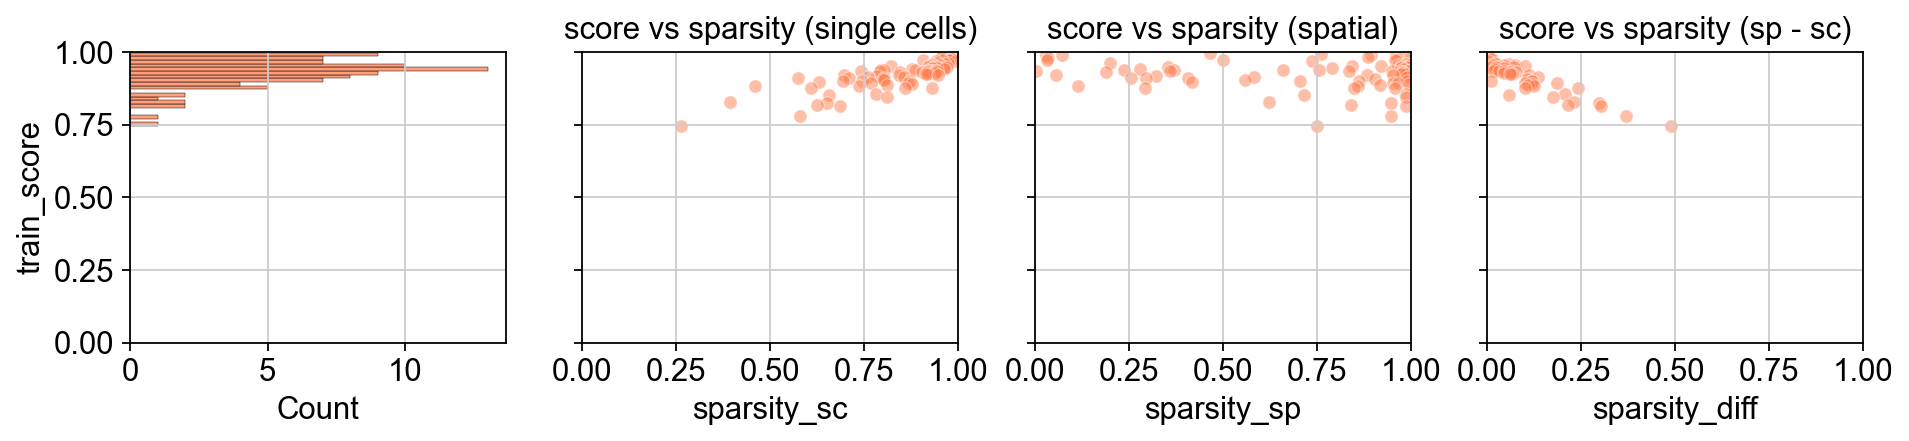

In [13]:
#  To get a deeper sense, Tangram also computes several scores, which are readily plotted
tg.plot_training_scores(ad_map_ctl, bins=20, alpha=0.5)

In [14]:
ad_ge_ctl = tg.project_genes(adata_map=ad_map_ctl, adata_sc=adata_sc_ctl)
ad_ge_ctl

AnnData object with n_obs × n_vars = 33391 × 22469
    obs: 'cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'n_counts', 'Slide_section', 'leiden', 'Sample_names', 'Slides', 'uniform_density', 'rna_count_based_density'
    var: 'features', 'n_cells', 'sparsity', 'is_training'
    uns: 'cell_subtype_colors', 'training_genes', 'overlap_genes'

In [15]:
genes = ["trem2", "il1b", "vsig4"]
ad_map_ctl.uns["train_genes_df"].loc[genes]

train_score  sparsity_sc  sparsity_sp  sparsity_diff
trem2     0.977813     0.986963     0.968914      -0.018049
il1b      0.936275     0.936012     0.951424       0.015412
vsig4     0.937596     0.918984     0.756970      -0.162013

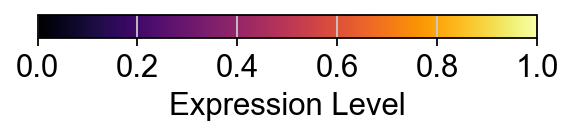

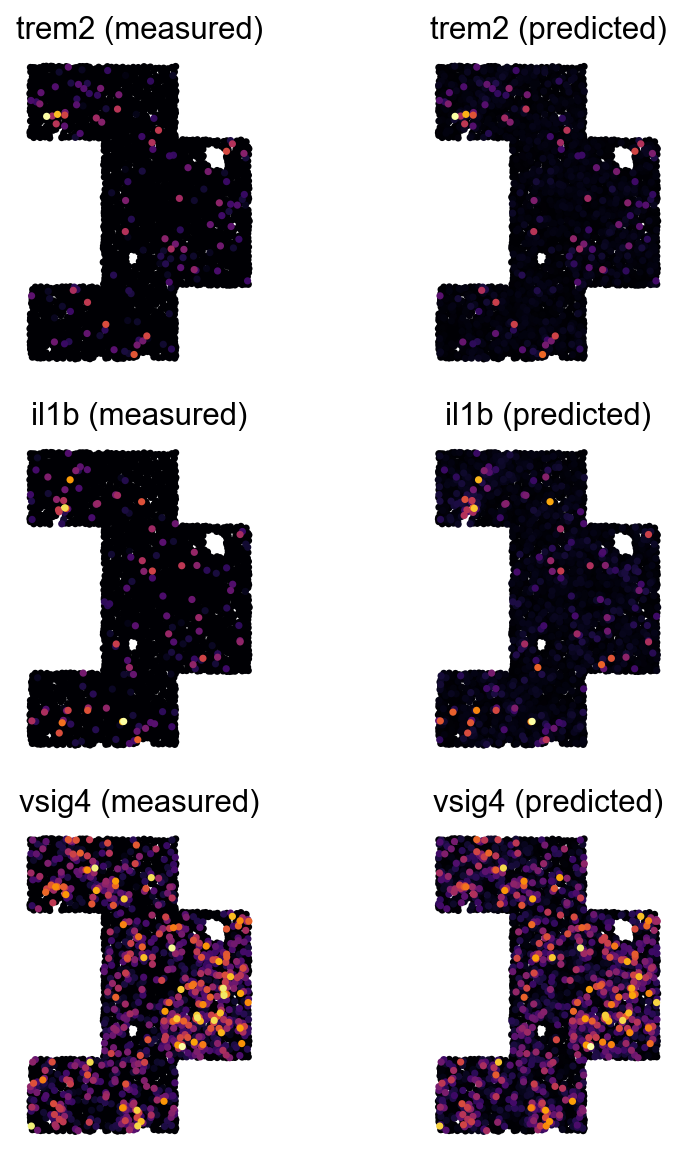

<Figure size 320x320 with 0 Axes>

In [54]:
# The comparison between original measurements on predicted ones is easily done with tangram
genes = ["trem2", "il1b", "vsig4"]
ax=tg.plot_genes(
    genes,
    adata_measured=merged_adata_ctl[merged_adata_ctl.obs.Slide_section == "D2-4"],
    adata_predicted=ad_ge_ctl[ad_ge_ctl.obs.Slide_section == "D2-4"],
    #perc=0.02
    #spot_size=50,
)
plt.show()
plt.savefig("Control_B1_1_Measured_predicted_example.pdf")

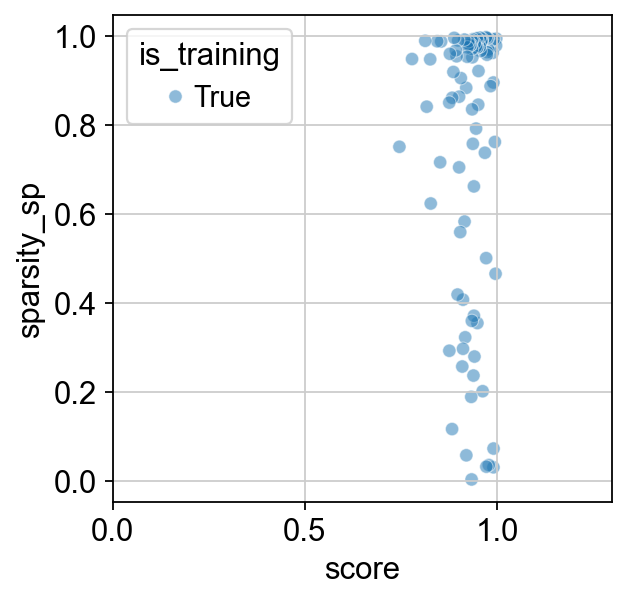

In [16]:
#tg.pp_adatas(adata_sc, adata_st, genes=markers)
df_all_genes = tg.compare_spatial_geneexp(ad_ge_ctl, merged_adata_ctl, adata_sc_ctl)
df_all_genes
#tg.plot_auc(df_all_genes);
sns.scatterplot(data=df_all_genes, x='score', y='sparsity_sp', hue='is_training', alpha=.5);  # for legacy
plt.xlim(0, 1.3)  # Set x-axis limits
plt.show()

### Plotting genes that were not part of the training data

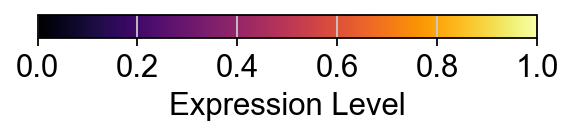

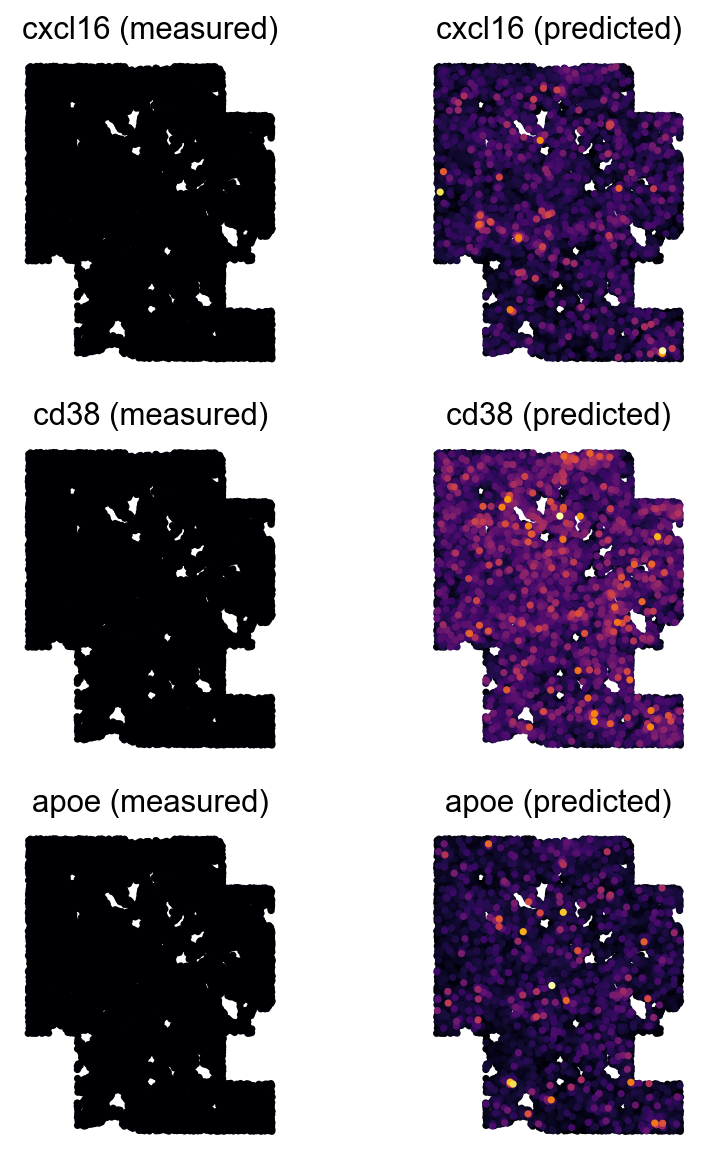

<Figure size 320x320 with 0 Axes>

In [76]:
genes = ["cxcl16", "cd38", "apoe"]
ax=tg.plot_genes(
    genes,
    adata_measured=merged_adata_ctl[merged_adata_ctl.obs.Slide_section == "D2-2"],
    adata_predicted=ad_ge_ctl[ad_ge_ctl.obs.Slide_section == "D2-2"]
)
plt.show()
# Save the plot as a PDF
plt.savefig("Example_plot.pdf", format="pdf")

In [62]:
ad_ge_ctl.var_names

Index(['xkr4', 'gm19938', 'rp1', 'sox17', 'gm37587', 'mrpl15', 'lypla1',
       'tcea1', 'rgs20', 'atp6v1h',
       ...
       'prss34', 'tulp1', 'gm30420', 'gm50162', 'slc22a28', 'golga7b',
       'mageb16', 'cnksr2', 'gm15241', 'zfy1'],
      dtype='object', length=23012)

### Validation on expression level

In [118]:
control_markers = ["C1qb","c1qa","apoe","ms4a7","c1qc","ctss","acp5","itm2b","cd63","itga9","cxcl16"]

In [ ]:
fig, ax = plt.subplots(1, len(control_markers), figsize=(25, 6.8), sharey=True)
for i, marker in enumerate(control_markers):
    # Retrieving measured counts
    measured = sc.get.obs_df(merged_adata_ctl[merged_adata_ctl.obs.Slide_section == "A1-2"], [marker, "tangram_ct_pred"])
    # Calculating measured expression levels
    measured["expression_level"] = (
        MinMaxScaler().fit(measured[[marker]]).transform(measured[[marker]])
    )

    # Retrieving measured counts
    predicted = sc.get.obs_df(ad_ge_ctl, [marker, "cell_subtype"])
    # Calculating predicted expression levels
    predicted["expression_level"] = (
        MinMaxScaler().fit(predicted[[marker]]).transform(predicted[[marker]])
    )

    sns.violinplot(
        data=pd.concat(
            [measured, predicted], keys=["measured", "predicted"], names=["sample"]
        ).reset_index(),
        y="cell_type",
        x="expression_level",
        hue="sample",
        split=True,
        ax=ax[i],
    )
    ax[i].set_title(marker)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend().remove()
plt.tight_layout()
plt.show()

In [111]:
set(merged_adata_ctl.obs.Slide_section)

{'A1-2', 'A1-3', 'A1-4', 'A1-5', 'A2-2', 'A2-3', 'A2-4', 'D1-1'}

In [144]:
#merged_adata_ctl.obs['tangram_ct_pred']=merged_adata_ctl.obsm['tangram_ct_pred']
merged_adata_ctl.obs

cell             x             y  \
Cell1_43_2174                Cell1_43_2174     43.012500   2174.041667   
Cell2_35_2314                Cell2_35_2314     34.677500   2314.003750   
Cell3_2171_91                Cell3_2171_91   2171.299539     91.230415   
Cell4_2174_192              Cell4_2174_192   2173.641631    191.978541   
Cell5_144_2254              Cell5_144_2254    144.360551   2254.329799   
...                                    ...           ...           ...   
Cell39095_9343_9345    Cell39095_9343_9345   9343.109091   9344.745455   
Cell39101_16286_3817  Cell39101_16286_3817  16286.217391   3817.275362   
Cell39114_4825_7323    Cell39114_4825_7323   4825.369565   7322.971014   
Cell39157_9124_11964  Cell39157_9124_11964   9123.812500  11964.500000   
Cell39174_7194_9512    Cell39174_7194_9512   7193.523810   9512.365079   

                      n_transcripts  density  elongation     area  \
Cell1_43_2174                   240  0.05245       2.094   4576.0   
Cell2_35_2314                   800  0.04969       8.677  16100.0   
Cell3_2171_91                   217  0.05889       2.329   3685.0   
Cell4_2174_192                  466  0.08507       1.923   5478.0   
Cell5_144_2254                  943  0.04953       3.363  19040.0   
...                             ...      ...         ...      ...   
Cell39095_9343_9345              55  0.02963       8.712   1856.0   
Cell39101_16286_3817             69  0.04835       2.237   1427.0   
Cell39114_4825_7323             138  0.03485       3.181   3960.0   
Cell39157_9124_11964             64  0.02883       1.774   2220.0   
Cell39174_7194_9512              63  0.04245       6.230   1484.0   

                      avg_confidence  n_genes_by_counts  \
Cell1_43_2174                 0.9958                 30   
Cell2_35_2314                 0.9974                 39   
Cell3_2171_91                 0.9925                 26   
Cell4_2174_192                0.9984                 23   
Cell5_144_2254                0.9961                 31   
...                              ...                ...   
Cell39095_9343_9345           0.9996                 12   
Cell39101_16286_3817          0.9999                 13   
Cell39114_4825_7323           0.9988                  9   
Cell39157_9124_11964          1.0000                 23   
Cell39174_7194_9512           0.9997                 10   

                      log1p_n_genes_by_counts  ...  \
Cell1_43_2174                        3.433987  ...   
Cell2_35_2314                        3.688879  ...   
Cell3_2171_91                        3.295837  ...   
Cell4_2174_192                       3.178054  ...   
Cell5_144_2254                       3.465736  ...   
...                                       ...  ...   
Cell39095_9343_9345                  2.564949  ...   
Cell39101_16286_3817                 2.639057  ...   
Cell39114_4825_7323                  2.302585  ...   
Cell39157_9124_11964                 3.178054  ...   
Cell39174_7194_9512                  2.397895  ...   

                      pct_counts_in_top_10_genes  pct_counts_in_top_20_genes  \
Cell1_43_2174                          83.333333                   95.000000   
Cell2_35_2314                          86.250000                   95.500000   
Cell3_2171_91                          86.635945                   97.235023   
Cell4_2174_192                         95.064378                   99.356223   
Cell5_144_2254                         89.925769                   97.560976   
...                                          ...                         ...   
Cell39095_9343_9345                    96.363636                  100.000000   
Cell39101_16286_3817                   95.652174                  100.000000   
Cell39114_4825_7323                   100.000000                  100.000000   
Cell39157_9124_11964                   78.125000                   95.312500   
Cell39174_7194_9512                   100.000000                  100.000000   

 

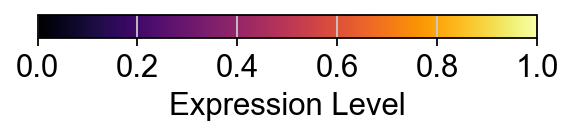

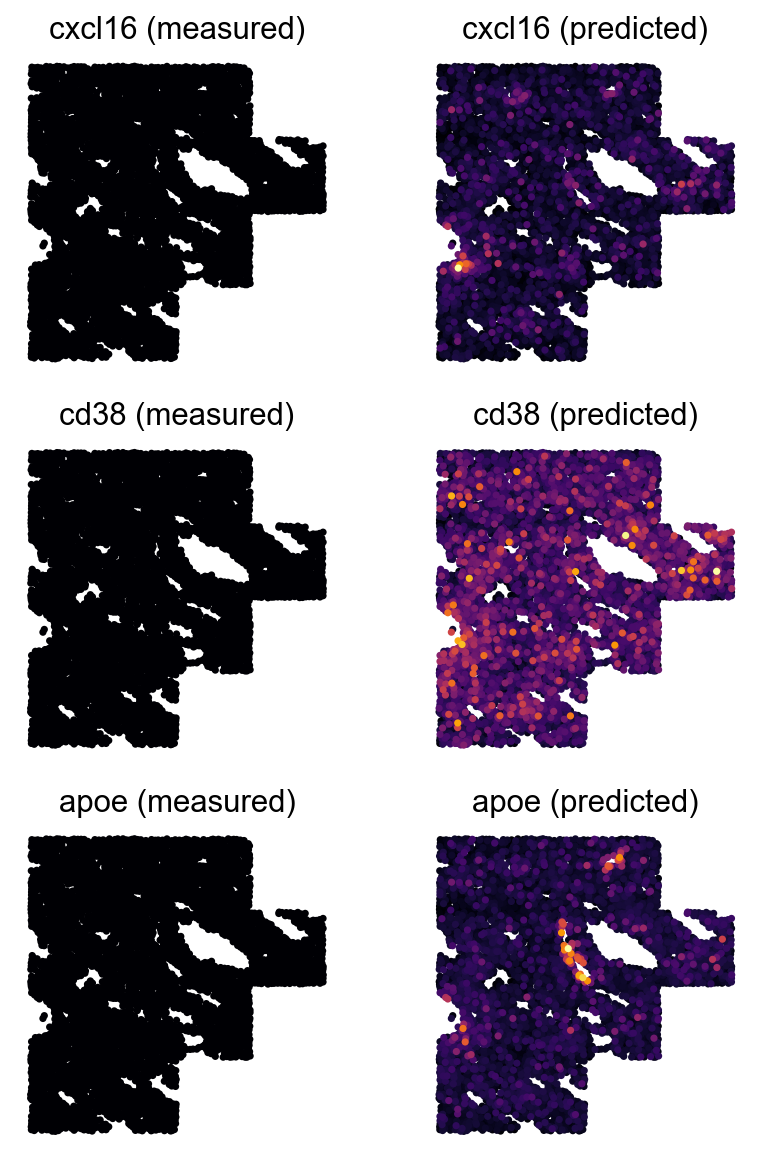

In [29]:
genes = ["cxcl16", "cd38", "apoe"]
ax=tg.plot_genes(
    genes,
    adata_measured=merged_adata_ctl[merged_adata_ctl.obs.Slide_section == "C2-2"],
    adata_predicted=ad_ge_ctl[ad_ge_ctl.obs.Slide_section == "C2-2"]
)
plt.show()

In [30]:
#adata_sc_ctl
#adata_sc_ctl.write("Tangram_allsubclusters_Control_RESOLVE_Control_adsc.h5ad")
merged_adata_ctl.write("Tangram_allsubclusters_Control_RESOLVE_Control_mergedST.h5ad")

ad_map_ctl.write("Tangram_allsubclusters_Control_RESOLVE_Control_admap.h5ad")
ad_ge_ctl.write("Tangram_allsubclusters_Control_RESOLVE_Control_adge.h5ad")

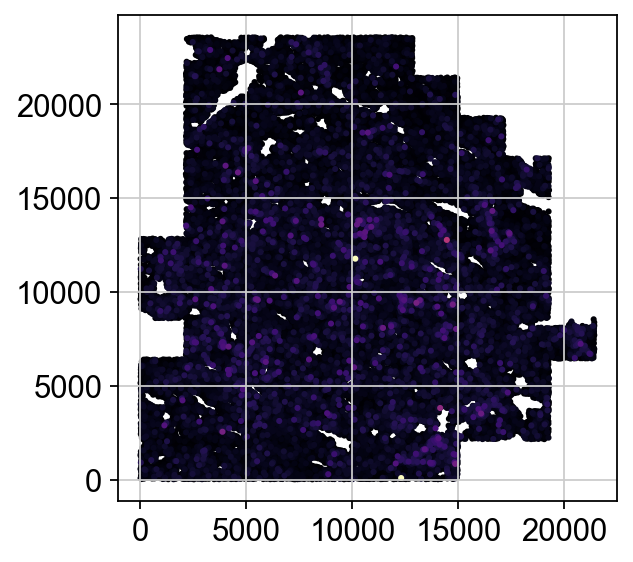

In [156]:
tg.quick_plot_gene(gene="cxcl16",adata=ad_ge_ctl[ad_ge_ctl.obs.Slide_section == "D1-1"], s=3,cmap="magma")

## Enrichment of signatures

In [184]:
import decoupler as dc


#### Read signatures from the populations

In [207]:
#read signature from excel file
Monocyticcell_clusters = pd.read_excel('/Users/m.ando/surfdrive - Masami Ando Kuri@surfdrive.surf.nl/Documents/HCC/NASH/scRNAseq/CANIL/Theo/Monocyticcells_12_clusters/Myelo_Markers_res_0_6_DT.xlsx',sheet_name=0) 
Tcells_clusters = pd.read_excel('/Users/m.ando/surfdrive - Masami Ando Kuri@surfdrive.surf.nl/Documents/HCC/NASH/scRNAseq/CANIL/Theo/Subclusters - DT/2nd iteration/T_cell_300Markers_res_0_25 - DT.xlsx',sheet_name=0) 

Monocyticcell_clusters = Monocyticcell_clusters.iloc[1:,0:12].melt()
Tcells_clusters = Tcells_clusters.iloc[1:,0:8].melt()



In [216]:
#Concatenate signatures
signatures = pd.concat([Monocyticcell_clusters, Tcells_clusters])
signatures.rename(columns={'variable': 'geneset', 'value': 'genesymbol'}, inplace=True)
signatures = signatures.reset_index(drop=True)
signatures.drop_duplicates()

signatures['genesymbol'] = signatures['genesymbol'].str.lower()

In [223]:
dc.run_ora(ad_ge_ctl,signatures.drop_duplicates(),source="geneset",target="genesymbol",n_background= 23487,use_raw=False)
#dc.run_aucell(ad_ge_ctl[ad_ge_ctl.obs.Slide_section == "D1-1"],signatures.drop_duplicates(),source="geneset",target="genesymbol",use_raw=False)


In [231]:
#Copy results under obs
#For now only overrep results
signatures_colnames = list(ad_ge_ctl.obsm["ora_pvals"])

ad_ge_ctl.obs[signatures_colnames] = ad_ge_ctl.obsm["ora_pvals"][signatures_colnames]
ad_ge_ctl.obs

cell             x             y  \
Cell1_43_2174                Cell1_43_2174     43.012500   2174.041667   
Cell2_35_2314                Cell2_35_2314     34.677500   2314.003750   
Cell3_2171_91                Cell3_2171_91   2171.299539     91.230415   
Cell4_2174_192              Cell4_2174_192   2173.641631    191.978541   
Cell5_144_2254              Cell5_144_2254    144.360551   2254.329799   
...                                    ...           ...           ...   
Cell39095_9343_9345    Cell39095_9343_9345   9343.109091   9344.745455   
Cell39101_16286_3817  Cell39101_16286_3817  16286.217391   3817.275362   
Cell39114_4825_7323    Cell39114_4825_7323   4825.369565   7322.971014   
Cell39157_9124_11964  Cell39157_9124_11964   9123.812500  11964.500000   
Cell39174_7194_9512    Cell39174_7194_9512   7193.523810   9512.365079   

                      n_transcripts  density  elongation     area  \
Cell1_43_2174                   240  0.05245       2.094   4576.0   
Cell2_35_2314                   800  0.04969       8.677  16100.0   
Cell3_2171_91                   217  0.05889       2.329   3685.0   
Cell4_2174_192                  466  0.08507       1.923   5478.0   
Cell5_144_2254                  943  0.04953       3.363  19040.0   
...                             ...      ...         ...      ...   
Cell39095_9343_9345              55  0.02963       8.712   1856.0   
Cell39101_16286_3817             69  0.04835       2.237   1427.0   
Cell39114_4825_7323             138  0.03485       3.181   3960.0   
Cell39157_9124_11964             64  0.02883       1.774   2220.0   
Cell39174_7194_9512              63  0.04245       6.230   1484.0   

                      avg_confidence  n_genes_by_counts  \
Cell1_43_2174                 0.9958                 30   
Cell2_35_2314                 0.9974                 39   
Cell3_2171_91                 0.9925                 26   
Cell4_2174_192                0.9984                 23   
Cell5_144_2254                0.9961                 31   
...                              ...                ...   
Cell39095_9343_9345           0.9996                 12   
Cell39101_16286_3817          0.9999                 13   
Cell39114_4825_7323           0.9988                  9   
Cell39157_9124_11964          1.0000                 23   
Cell39174_7194_9512           0.9997                 10   

                      log1p_n_genes_by_counts  ...  Malat1_Monocytic cells  \
Cell1_43_2174                        3.433987  ...            5.097149e-58   
Cell2_35_2314                        3.688879  ...            3.110374e-43   
Cell3_2171_91                        3.295837  ...            2.154484e-53   
Cell4_2174_192                       3.178054  ...            3.191026e-51   
Cell5_144_2254                       3.465736  ...            2.154484e-53   
...                                       ...  ...                     ...   
Cell39095_9343_9345                  2.564949  ...            1.184816e-55   
Cell39101_16286_3817                 2.639057  ...            2.154484e-53   
Cell39114_4825_7323                  2.302585  ...            3.957619e-49   
Cell39157_9124_11964                 3.178054  ...            2.154484e-53   
Cell39174_7194_9512                  2.397895  ...            3.110374e-43   

                        Mertk+ KCs  Migratory DCs  Naive T cells  \
Cell1_43_2174         1.184816e-55   1.214536e-08  5.319974e-106   
Cell2_35_2314         3.957619e-49   7.462828e-04   4.543677e-97   
Cell3_2171_91         4.224491e-36   4.818326e-06  3.641373e-126   
Cell4_2174_192        1.194200e-29   2.892964e-05  1.048368e-104   
Cell5_144_2254        3.191026e-51   4.818326e-06  3.057393e-111   
...                            ...            ...            ...   
Cell39095_9343_9345   3.314196e-25   7.232780e-07  5.846279e-129   
Cell39101_16286_3817  1.189150e-26   9.830500e-08  7.362059e-101   
Cell39114_4825_7323   1.674141e-18   9.830500e-08  2.036569e-1

In [229]:
#pvals adjusted and transformation function
import scipy as sci
def adj_minuslog10 (pval):
    adj_transformed = np.log10(sci.stats.false_discovery_control(pval))*-1
    return(adj_transformed)

In [233]:
#pvals adjusted

t =ad_ge_ctl.obs[signatures_colnames].apply(lambda x: adj_minuslog10(x), axis=0).add_prefix('adj_hh_log10_')
t_colnames = list(t)
ad_ge_ctl.obs[t_colnames]=t

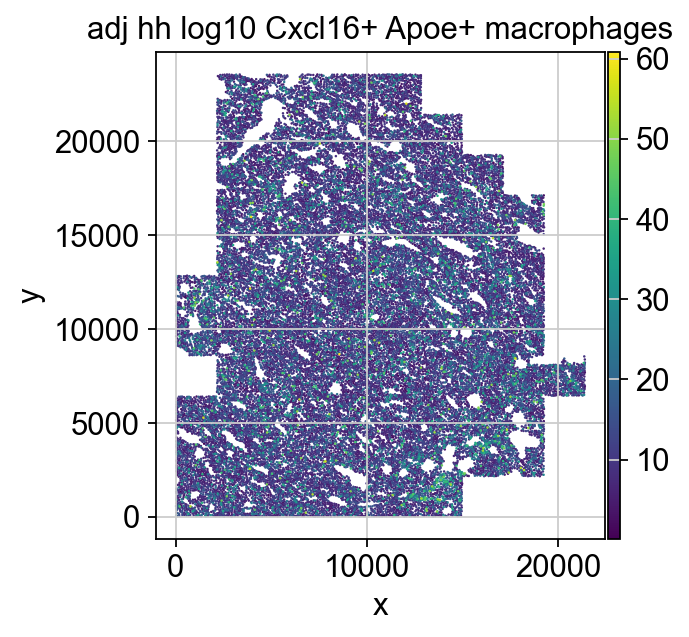

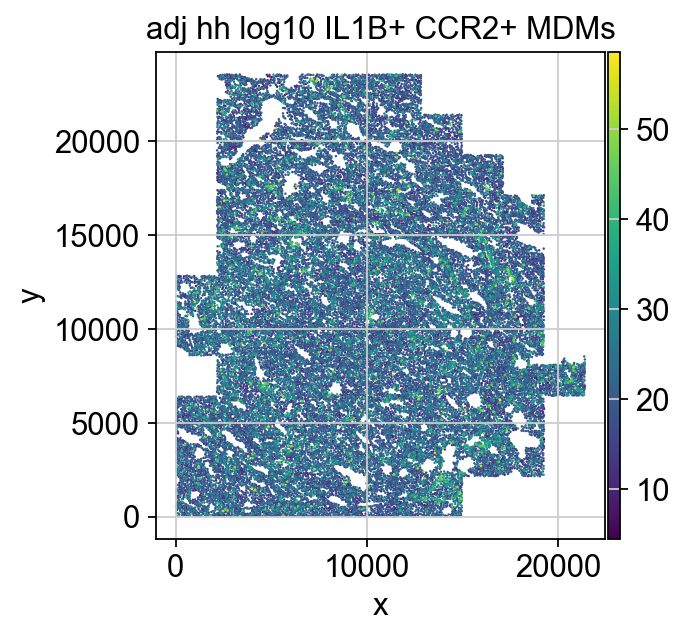

In [250]:
genes = ['adj_hh_log10_Cxcl16+ Apoe+ macrophages','adj_hh_log10_IL1B+ CCR2+ MDMs']
#ax=tg.quick_plot_gene(
 #   genes,
#3adata_measured=merged_adata_ctl[merged_adata_ctl.obs.Slide_section == "A1-2"],
 #   ad_ge_ctl[ad_ge_ctl.obs.Slide_section == "D1-1"]
#)
#plt.show()
# Save the plot as a PDF
#plt.savefig("Example_plot.pdf", format="pdf")

sc.pl.scatter(
    ad_ge_ctl[ad_ge_ctl.obs.Slide_section == "D1-1"],x="x",y="y",color='adj_hh_log10_Cxcl16+ Apoe+ macrophages', frameon=False,size=5
)

sc.pl.scatter(
    ad_ge_ctl[ad_ge_ctl.obs.Slide_section == "D1-1"],x="x",y="y",color='adj_hh_log10_IL1B+ CCR2+ MDMs', frameon=False,size=5
)

sc.pl.scatter(
    ad_ge_ctl[ad_ge_ctl.obs.Slide_section == "D1-1"],x="x",y="y",color='adj_hh_log10_IL1B+ CCR2+ MDMs', frameon=False,size=5
)

In [32]:
merged_adata_ctl.obs['tangram_celltype_mostabund'] =  merged_adata_ctl.obsm['tangram_ct_pred'].idxmax(axis=1)
merged_adata_ctl.obs['tangram_celltype_mostabund_filtered']=merged_adata_ctl.obs['tangram_celltype_mostabund']


In [33]:
merged_adata_ctl.obs['tangram_celltype_mostabund_filtered'][~merged_adata_ctl.obs['tangram_celltype_mostabund_filtered'].isin(['IL1B+CCR2+_MDMs','Cxcl16+Apoe+_Mph', 'Prostaglandin+_KCs', 'Exh_CD8_T'] )]="NA"

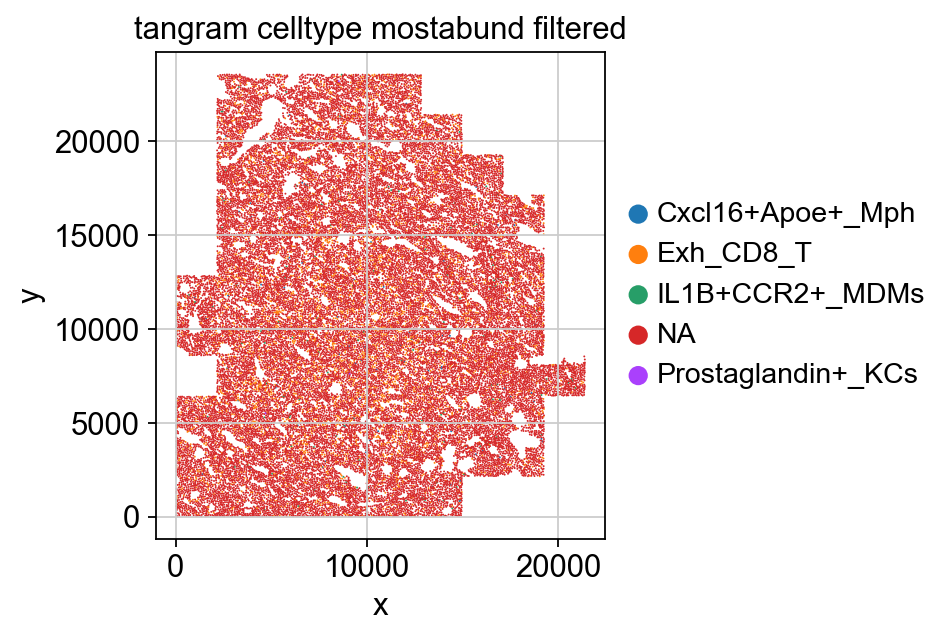

In [295]:
sc.pl.scatter(
    merged_adata_ctl[merged_adata_ctl.obs.Slide_section == "D1-1"],x="x",y="y",color='tangram_celltype_mostabund_filtered', frameon=None,size=3,
save="D1-1_tangram_pred_filtered.pdf")



In [34]:
import re
#Ran this line in the first iteration
merged_adata_ctl.obs['tangram_celltype_mostabund'] = merged_adata_ctl.obs['tangram_celltype_mostabund'].astype('category')


merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs']=merged_adata_ctl.obs['tangram_celltype_mostabund']
set(merged_adata_ctl.obs['tangram_celltype_mostabund'])
#Add categories
merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'] = (
    merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs']
    .cat.add_categories(["B_cells", "Neutrophils", "Plasma_cells","Hepatocytes","NK_cells","pDCs","Endothelial_cells"])
)

merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'][merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'].str.contains(r'_B', regex=True)]="B_cells"
merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'][merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'].str.contains(r'_Neu', regex=True)]="Neutrophils"
merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'][merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'].str.contains(r'_Plasm', regex=True)]="Plasma_cells"
merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'][merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'].str.contains(r'_Hep', regex=True)]="Hepatocytes"
merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'][merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'].str.contains(r'_NK', regex=True)]="NK_cells"
merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'][merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'].str.contains(r'_pDCs', regex=True)]="pDCs"
merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'][merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'].str.contains(r'_EC', regex=True)]="Endothelial_cells"


set(merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'])
#set(merged_adata_ctl.obs['tangram_celltype_mostabund'])

merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'][~merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'].str.contains(r'_Mph|_Mono', regex=True)]


merged_adata_ctl.write("Tangram_allsubclusters_Control_RESOLVE_Control_mergedST.h5ad")



### Neighborhood enrichment analysis

In [95]:

#set(merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'][~merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'].str.contains(r'_Mph|_MDMs|_KCs|_Mono|_T', regex=True)])
#merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'].cat.remove_categories(['Activated_B', 'Apoc1+Aldob+_Hep', 'Bnip3l_Plasm', 'CD52+_EC', 'CD74+MHCII+_Hep','Cxcr2+Ccl6+_Neu ', 'Cytotoxic/Activated_NK','Exhausted_NK', 'Fatty_NK', 'Foxp1+Very_early_B', 'Foxp1+_pDCs','Hmgb2_Plasm', 'Homeostatic_EC','IL1B+_Neu','IL1Ra+PD-L1+_Neu','Igkc_Plasm', 'Irf8+_pDCs','Migratory_DCs', 'NA', 'Naive/Early_Ly6D+_B', 'Oncofetal_IGFBP3+_EC', 'Plasm_Fib', 'Prolif_DCs', 'Prostaglandin+IL1R+_EC', 'Retnlg_Neu','Tox+_Neu', 'VEGF+_EC', 'Vegfa+_Hep', '_EC', 'cDC1s', 'cDC2s', 'mixed_EC'])
merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'] = (
    merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs']
    .cat.remove_categories(['Activated_B', 'Apoc1+Aldob+_Hep', 'Bnip3l_Plasm', 'CD52+_EC','Cxcr2+Ccl6+_Neu ', 'Cytotoxic/Activated_NK','Exhausted_NK', 'Fatty_NK', 'Foxp1+Very_early_B', 'Foxp1+_pDCs','Hmgb2_Plasm', 'Homeostatic_EC','IL1B+_Neu',
       'IL1Ra+PD-L1+_Neu','Igkc_Plasm', 'Irf8+_pDCs','Migratory_DCs', 'NA', 'Naive/Early_Ly6D+_B', 'Oncofetal_IGFBP3+_EC', 'Plasm_Fib', 'Prolif_DCs', 'Prostaglandin+IL1R+_EC', 'Retnlg_Neu','Tox+_Neu', 'VEGF+_EC', 'Vegfa+_Hep', '_EC', 'cDC1s', 'cDC2s', 'mixed_EC'])
)

merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs'] = (
    merged_adata_ctl.obs['tangram_celltype_mostabund_mergedsubs']
    .cat.add_categories("Unknown")
    .fillna("Unknown")
)

In [100]:
import squidpy as sq

#sq.gr.spatial_neighbors(merged_adata_ctl)
#sq.gr.nhood_enrichment(merged_adata_ctl, cluster_key="tangram_celltype_mostabund_mergedsubs")

ImportError: cannot import name 'Coordinates' from partially initialized module 'xarray.core.coordinates' (most likely due to a circular import) (/opt/miniconda3/envs/tangram-env/lib/python3.10/site-packages/xarray/core/coordinates.py)

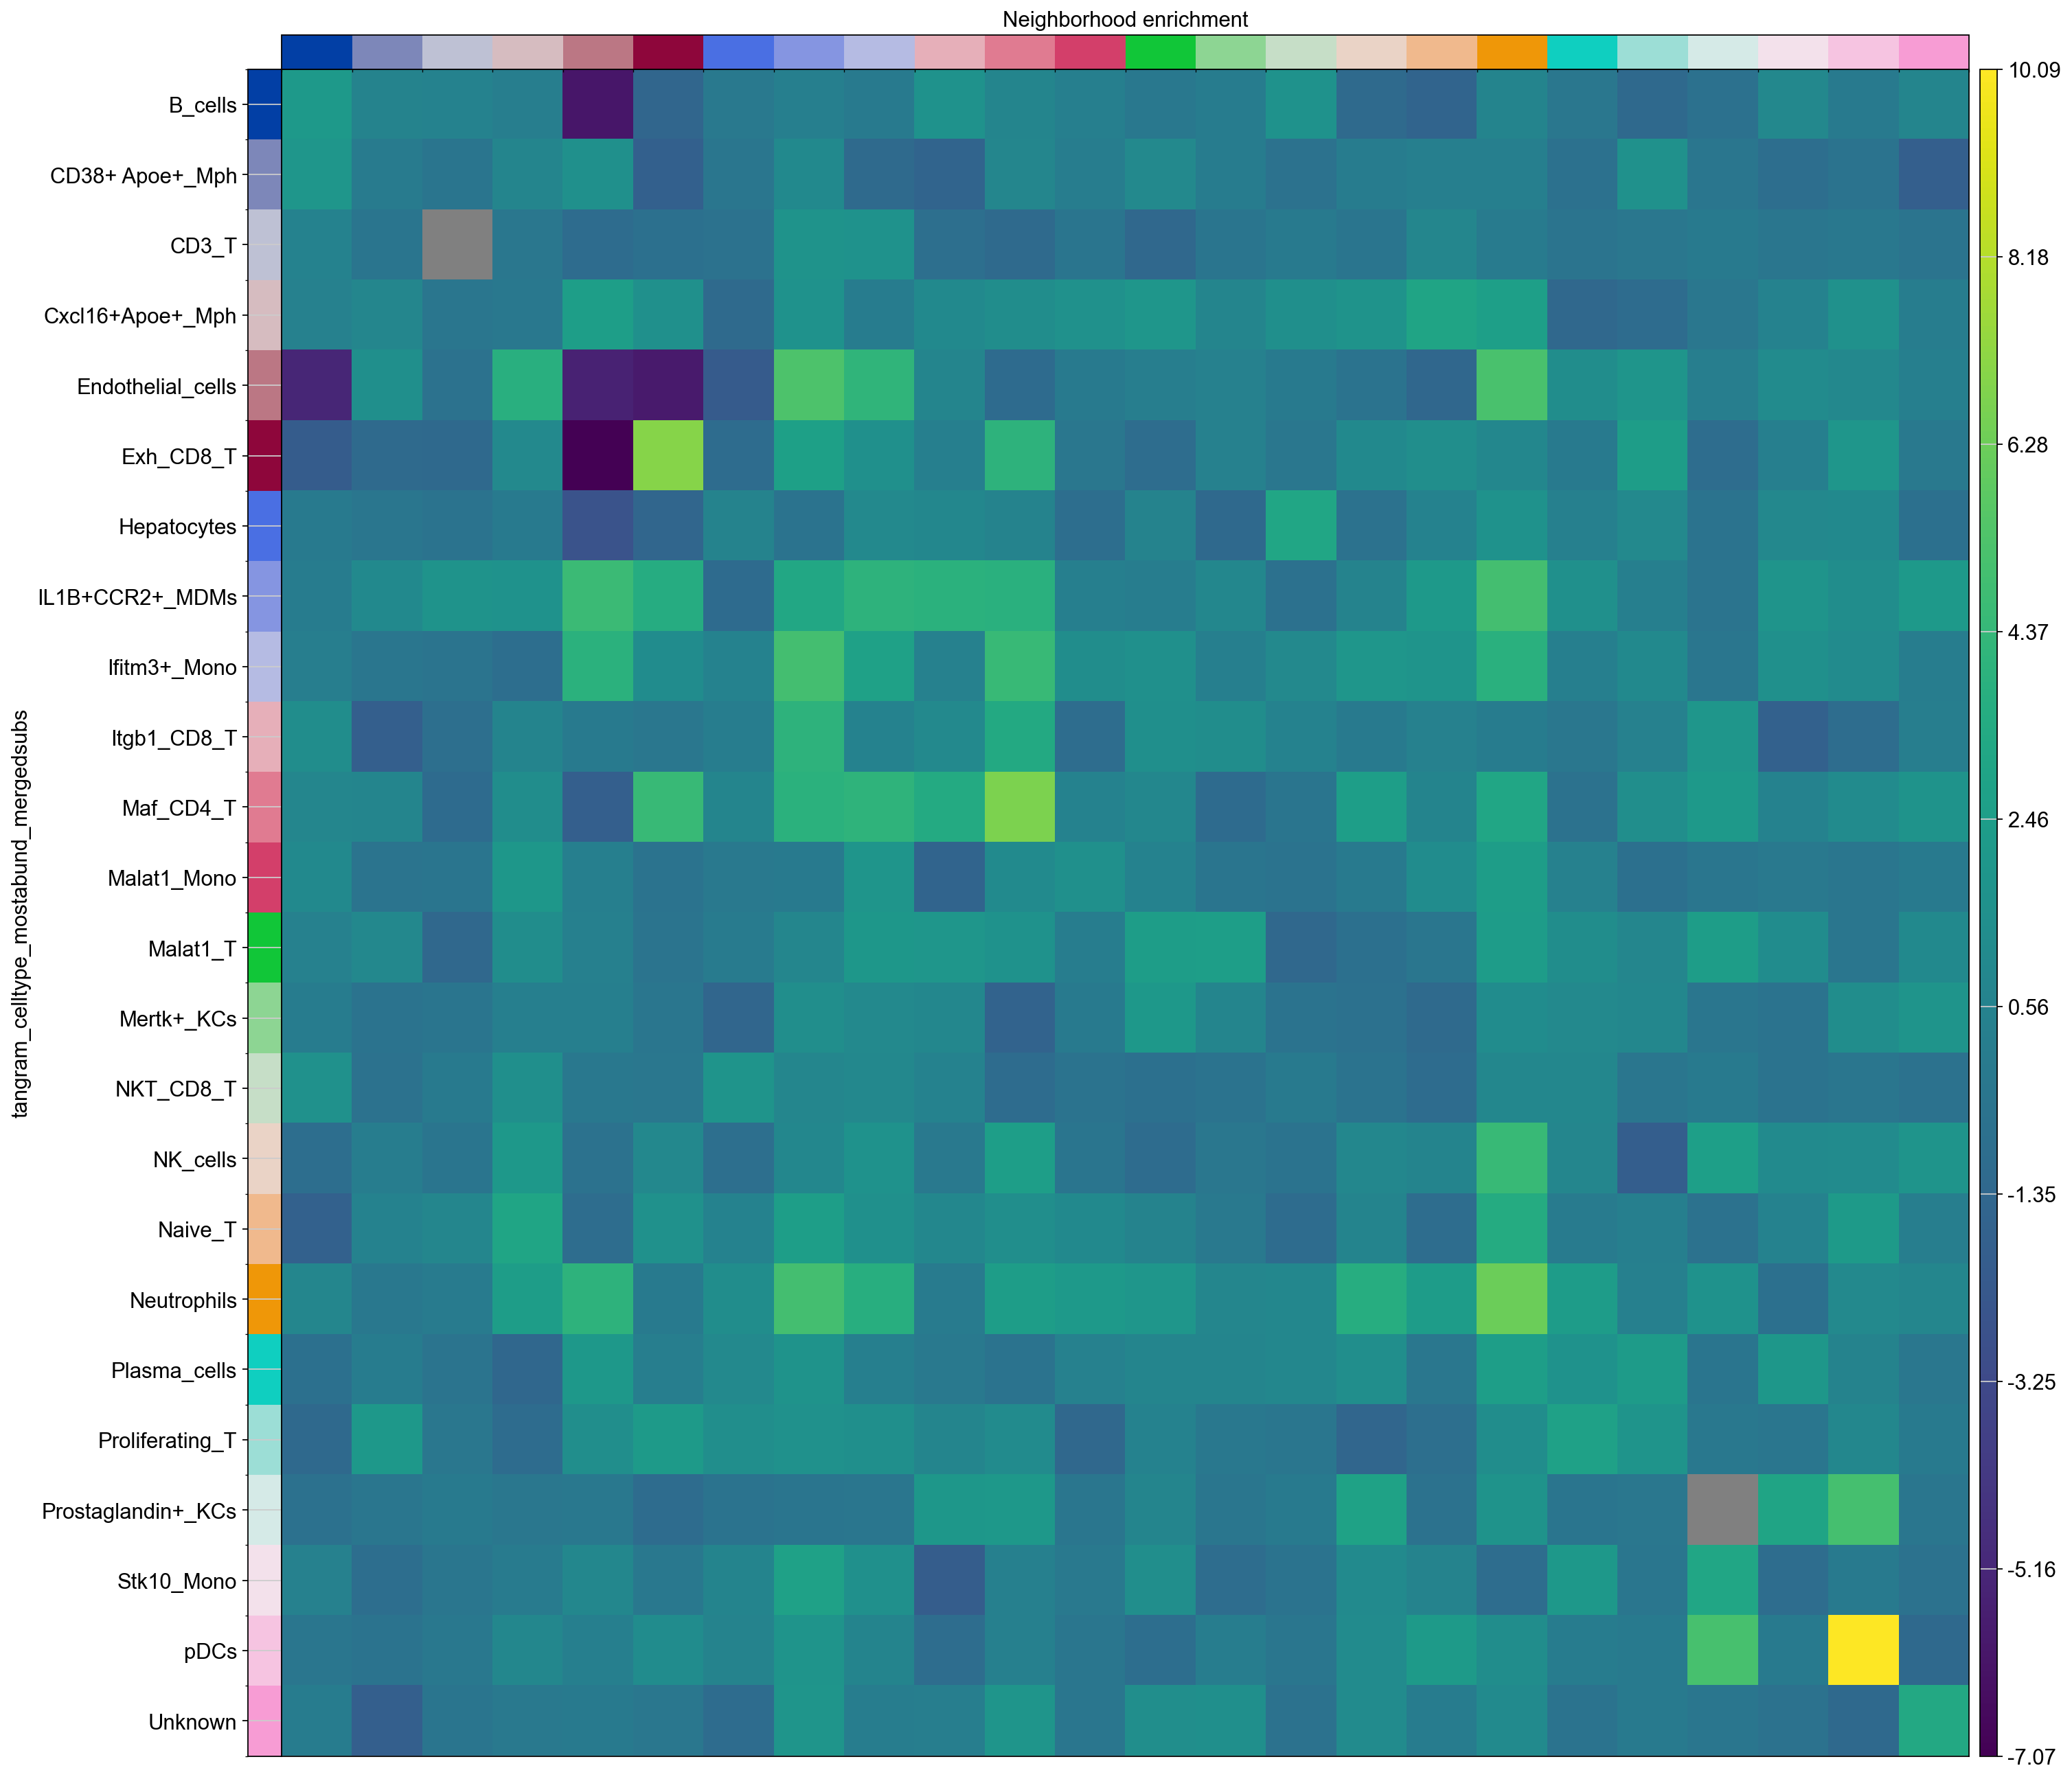

In [378]:
sq.pl.nhood_enrichment(merged_adata_ctl, cluster_key="tangram_celltype_mostabund_mergedsubs", save="Neighbourhood_enrichment_Mono_Tcell_others.pdf")

In [319]:
merged_adata_ctl.obsm['spatial']=merged_adata_ctl.obs.iloc[:,1:3].to_numpy()


Calculating co-occurrence probabilities for `50` intervals `1128` split combinations using `1` core(s)


  0%|                                                                                              | 0/1128 [00:00<?, ?/s]/opt/miniconda3/envs/tangram-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/tangram-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/tangram-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/tangram-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureW

Adding `adata.uns['tangram_celltype_mostabund_co_occurrence']`
Finish (0:14:22)


Calculating co-occurrence probabilities for `50` intervals `1128` split combinations using `1` core(s)


  0%|                                                                                              | 0/1128 [00:00<?, ?/s]/opt/miniconda3/envs/tangram-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/tangram-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/tangram-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/tangram-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureW

Adding `adata.uns['tangram_celltype_mostabund_co_occurrence']`
Finish (0:14:05)
ERROR: Unable to fetch palette, reason: 'tangram_celltype_mostabund_colors'. Using `None`.


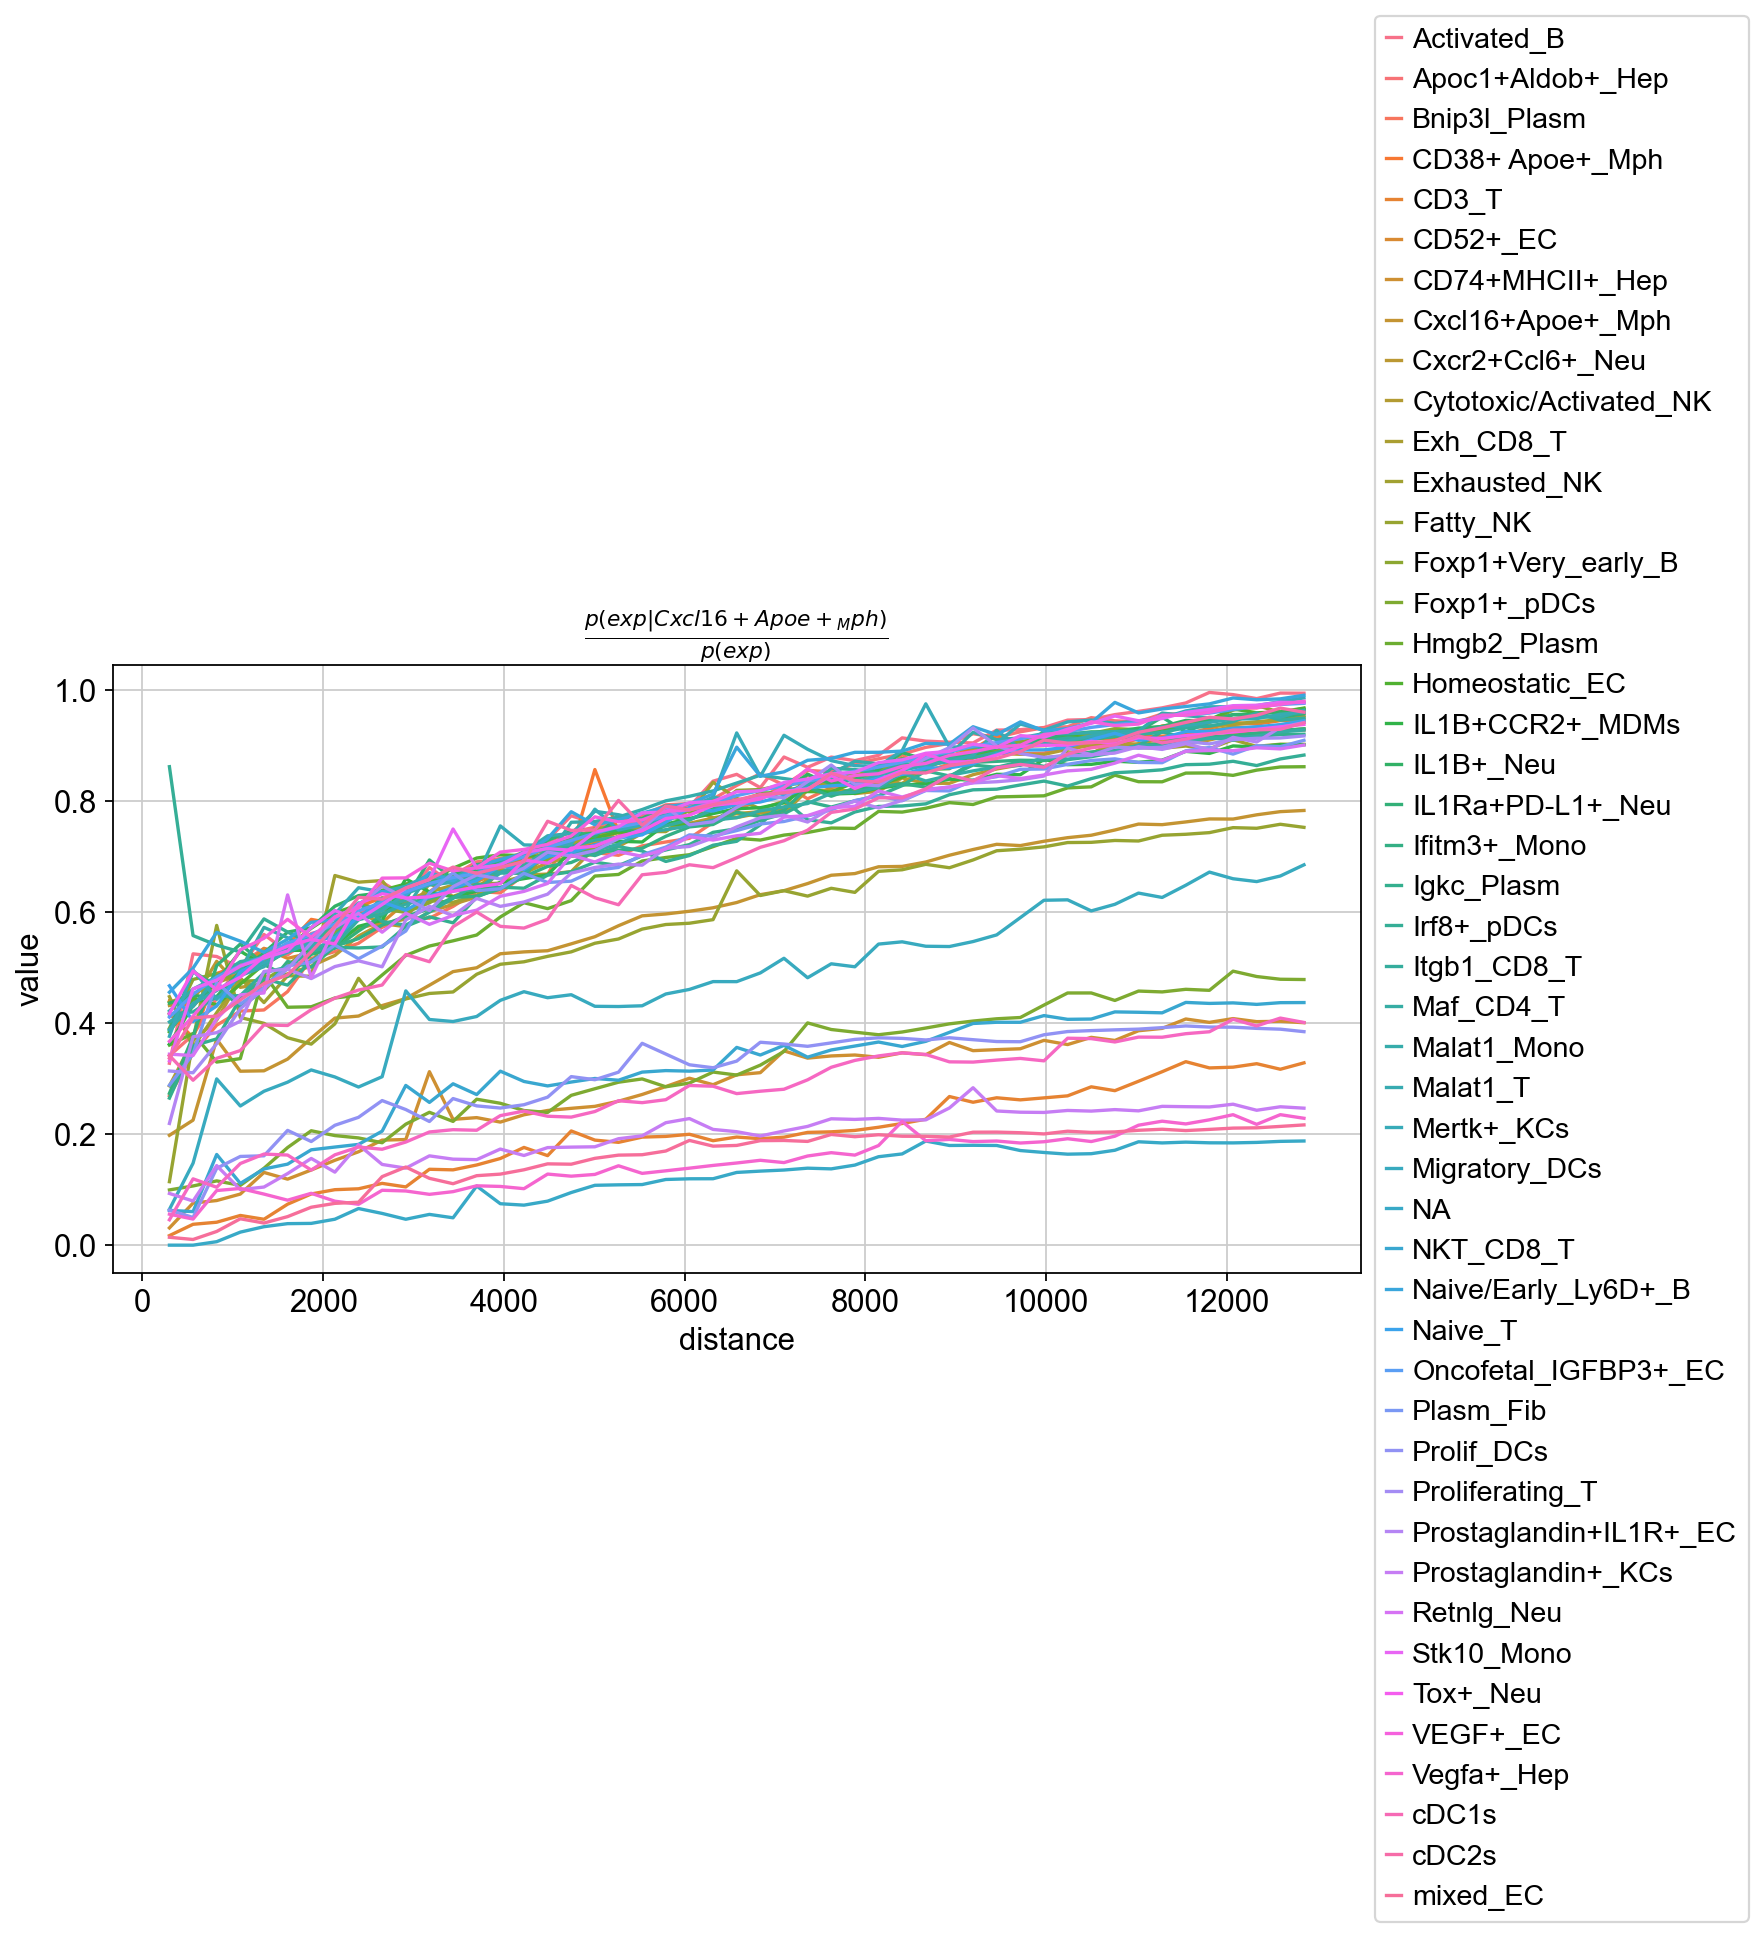

In [379]:
sq.gr.co_occurrence(merged_adata_ctl, cluster_key="tangram_celltype_mostabund")
sq.pl.co_occurrence(merged_adata_ctl,cluster_key="tangram_celltype_mostabund",clusters="Cxcl16+Apoe+_Mph",figsize=(10, 5))



In [334]:
from omnipath.interactions import import_intercell_network
from omnipath import clear_cache

sq.gr.ligrec(
    merged_adata_ctl,
    n_perms=100,
    cluster_key="tangram_celltype_mostabund",use_raw=False
)


PermissionError: [Errno 13] Permission denied: '/Users/m.ando/.config/omnipathdb.ini'

In [310]:
sq.pl.ligrec(
    adata,
    cluster_key="celltype_mapped_refined",
    source_groups="Lateral plate mesoderm",
    target_groups=["Control mesoderm", "Allantois"],
    means_range=(0.3, np.inf),
    alpha=1e-4,
    swap_axes=True,
)

AnnData object with n_obs × n_vars = 95987 × 88
    obs: 'cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'n_counts', 'Slide_section', 'leiden', 'Sample_names', 'Slides', 'uniform_density', 'rna_count_based_density', 'tangram_celltype_mostabund', 'tangram_celltype_mostabund_filtered'
    var: 'n_cells', 'sparsity'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'training_genes', 'overlap_genes', 'spatial', 'spatial_neighbors', 'tangram_celltype_mostabund_nhood_enrichment'
    obsm: 'spatial', 'X_pca', 'X_umap', 'X_pca_harmony', 'tangram_ct_pred'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

In [328]:
adata_sc_ctl.obs['']

AnnData object with n_obs × n_vars = 26267 × 23487
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'replicate', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.08', 'seurat_clusters', 'SCT_snn_res.0.07', 'batch', 'SCT_snn_res.0.06', 'SCT_snn_res.0.1', 'anchor_pred', 'celltype_wide', 'cell_type', 'cell_subtype'
    var: 'features', 'n_cells', 'sparsity'
    uns: 'cell_subtype_colors', 'training_genes', 'overlap_genes'
    obsm: 'X_umap'